In [11]:
# !pip install torch
# !pip install transformers
# !pip install json

In [5]:
import json
import torch
import random 
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer, BertForTokenClassification, AdamW

# Load the labeled dataset
with open("human_annotated_dataset.json", "r") as f:
    labeled_data = json.load(f)

# Prepare the data for training
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
labels = ["none", "hedge", "authority"]
label_map = {label: i for i, label in enumerate(labels)}

# Split the dataset into train and eval subsets
random.shuffle(labeled_data)
train_size = int(0.7 * len(labeled_data))
train_data = labeled_data[:train_size]
eval_data = labeled_data[train_size:]

max_length = 512  # Set the maximum sequence length to 512

# For the training dataset
train_dataset = []
for example in train_data:
    statement = example["statement"]
    encoding = tokenizer.encode_plus(
        statement,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )
    input_ids = encoding["input_ids"].squeeze()
    attention_mask = encoding["attention_mask"].squeeze()

    label_ids = [label_map["none"]] * max_length  # Initialize label_ids with "none"
    for term, details in example["matched_terms"].items():
        label = details['correct']  # Access the "correct" key for the label
        if label != "none":
            term_tokens = tokenizer.tokenize(term)
            term_indices = [i for i, token_id in enumerate(input_ids) if tokenizer.decode([token_id]).strip().lower() in term_tokens]
            for index in term_indices:
                label_ids[index] = label_map[label]

    train_dataset.append({
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": torch.tensor(label_ids),
    })

# For the evaluation dataset
eval_dataset = []
for example in eval_data:
    statement = example["statement"]
    encoding = tokenizer.encode_plus(
        statement,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )
    input_ids = encoding["input_ids"].squeeze()
    attention_mask = encoding["attention_mask"].squeeze()

    label_ids = [label_map["none"]] * max_length  # Initialize label_ids with "none"
    for term, details in example["matched_terms"].items():
        label = details['correct']  # Access the "correct" key for the label
        if label != "none":
            term_tokens = tokenizer.tokenize(term)
            term_indices = [i for i, token_id in enumerate(input_ids) if tokenizer.decode([token_id]).strip().lower() in term_tokens]
            for index in term_indices:
                label_ids[index] = label_map[label]

    eval_dataset.append({
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": torch.tensor(label_ids),
    })


# Set up the model and optimizer
model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels=len(labels))
optimizer = AdamW(model.parameters(), lr=2e-5)

# Fine-tune the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model.to(device)

batch_size = 8
epochs = 3

for epoch in range(epochs):
    for i in range(0, len(train_dataset), batch_size):
        batch = train_dataset[i:i+batch_size]
        
        input_ids = torch.stack([example["input_ids"] for example in batch]).to(device)
        attention_mask = torch.stack([example["attention_mask"] for example in batch]).to(device)
        labels = torch.stack([example["labels"] for example in batch]).to(device)

        model.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# Save the fine-tuned model
model.save_pretrained("pragmatic_markers_model")

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/mwise/.local/lib/python3.10/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Device: cuda
Evaluation Accuracy: 0.9980


In [10]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Evaluate the model
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for example in eval_dataset:
        input_ids = example["input_ids"].unsqueeze(0).to(device)
        attention_mask = example["attention_mask"].unsqueeze(0).to(device)
        labels = example["labels"].unsqueeze(0).to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits.argmax(dim=-1).squeeze().tolist()
        label_ids = labels.squeeze().tolist()

        # Append batch predictions and true labels, filtering out padding (-100)
        predictions.extend([p for p, l in zip(logits, label_ids) if l != -100])
        true_labels.extend([l for l in label_ids if l != -100])

# Calculate overall accuracy
accuracy = accuracy_score(true_labels, predictions)

# Determine the unique labels in true labels to correctly calculate metrics
unique_labels = sorted(set(true_labels))

# Calculate precision, recall, and F1-score for each class and macro averages
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, labels=unique_labels, average=None, zero_division=0)
macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(true_labels, predictions, average='macro', zero_division=0)

# Print metrics for each category, using unique_labels to match indices
for i, label_id in enumerate(unique_labels):
    reversed_label_map = {v: k for k, v in label_map.items()}
    label_name = reversed_label_map[label_id]
    print(f"{label_name} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1: {f1[i]:.4f}")

# Print macro-averaged metrics and overall accuracy
print(f"\nMacro-Averaged Precision: {macro_precision:.4f}")
print(f"Macro-Averaged Recall: {macro_recall:.4f}")
print(f"Macro-Averaged F1 Score: {macro_f1:.4f}")
print(f"Overall Accuracy: {accuracy:.4f}")

none - Precision: 0.9983, Recall: 0.9997, F1: 0.9990
hedge - Precision: 0.7959, Recall: 0.4615, F1: 0.5843
authority - Precision: 0.0000, Recall: 0.0000, F1: 0.0000

Macro-Averaged Precision: 0.5981
Macro-Averaged Recall: 0.4871
Macro-Averaged F1 Score: 0.5278
Overall Accuracy: 0.9980


### Confusion Matrix

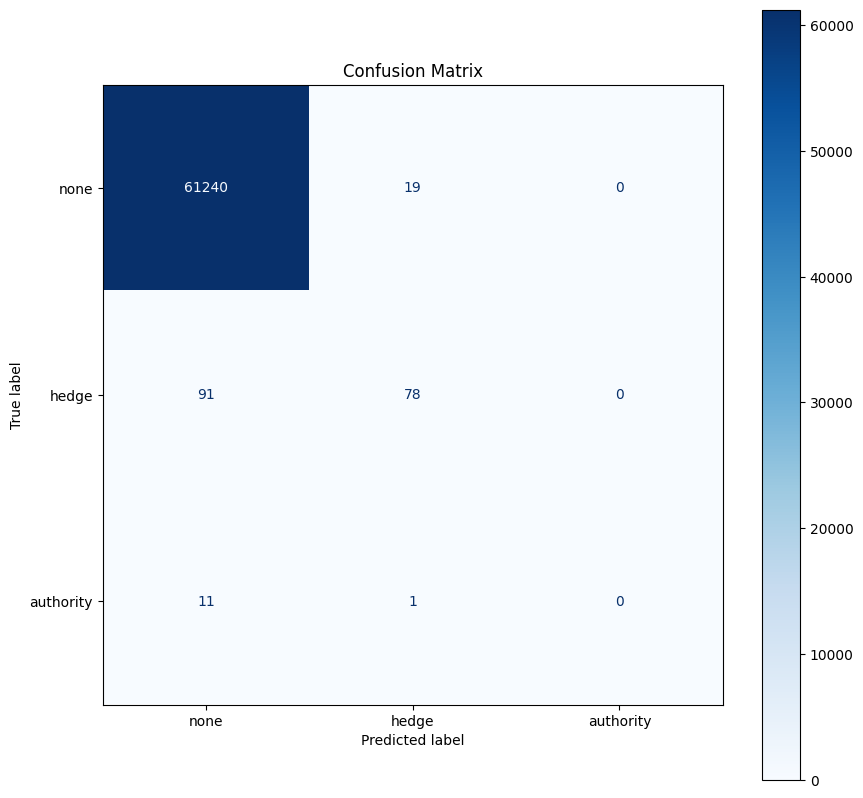

In [13]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions, labels=unique_labels)
display_labels = [reversed_label_map[label] for label in unique_labels]

# Display the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(values_format='d', cmap='Blues', ax=ax)
plt.title('Confusion Matrix')
plt.show()